<a href="https://colab.research.google.com/github/MysticalHeat/python_labs/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%9B%D0%B0%D0%B1_3_%2B_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Базовая классификация текста

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

В этом файле демонстрируется классификация текста, начиная с обычных текстовых файлов, хранящихся на диске. Вы обучите двоичный классификатор выполнять анализ настроений в наборе данных IMDB.

**В конце блокнота вы можете попробовать выполнить упражнение, в котором вы научите многоклассовый классификатор предсказывать тег для вопроса по программированию в Stack Overflow**

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
print(tf.__version__)

2.18.0


## Анализ настроений

Этот блокнот обучает модель анализа настроений классифицировать рецензии на фильмы как *положительные* или *негативные* в зависимости от текста рецензии. Это пример *бинарной* (или двухклассовой) классификации, важной и широко применимой задачи машинного обучения.

Вы будете использовать [Большой набор данных обзоров фильмов](https://ai.stanford.edu/~amaas/data/sentiment/), который содержит текст 50 000 обзоров фильмов из [Интернет-базы данных фильмов](https:// www.imdb.com/). Они разделены на 25 000 отзывов для обучения и 25 000 отзывов для тестирования. Наборы для обучения и тестирования *сбалансированы*, то есть содержат равное количество положительных и отрицательных отзывов.


### Загрузите и изучите набор данных IMDB

Давайте загрузим и извлечем набор данных, а затем исследуем структуру каталогов.

In [6]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join('/content', 'stack_overflow_16k')

In [7]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'csharp', 'javascript', 'python']

Каталоги `aclImdb/train/pos` и `aclImdb/train/neg` содержат множество текстовых файлов, каждый из которых представляет собой отдельную рецензию на фильм. Давайте взглянем на один из них.

In [10]:
sample_file = os.path.join(train_dir, 'java/1000.txt')
with open(sample_file) as f:
  print(f.read())

"how to stop a keypad from returning upper case letters blank i have a keyboard that returns how many keypresses it would take to make a string on a user input keyboard, but i'm supposed to only have it calculate strings that dont have any uppercase or punctuation. how can i have it exclude punctuation or strings with upper case letters in them? ..public class keypad..char [][] letters; ...public keypad(string chars, int rowlength).{.    int column = chars.length()/rowlength;.    if(chars.length()%rowlength!=0) {.        column++;.    }..    letters = new char[column][rowlength]; .    for(int i = 0, n=0; i &lt; letters.length ; i++) {.        for(int j = 0 ; n &lt; chars.length() &amp;&amp; j &lt; letters[i].length ; j++, n++) {.            letters[i][j] = chars.charat(n);.        }.    }..}....public int[]  find(char letter) {.    int [] coordinates;.    coordinates = new int [2];.    for(int i=0; i&lt;letters.length; i++) {.        for(int j = 0; j&lt;letters[i].length; j++) {..     

### Загрузите набор данных

Далее вы загрузите данные с диска и преобразуете их в формат, подходящий для обучения. Для этого вы воспользуетесь полезной утилитой [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory), которая ожидает следующую структуру каталогов.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

Чтобы подготовить набор данных для бинарной классификации, вам понадобятся две папки на диске, соответствующие «class_a» и «class_b». Это будут положительные и отрицательные рецензии на фильмы, которые можно найти в `aclImdb/train/pos` и `aclImdb/train/neg`. Поскольку набор данных IMDB содержит дополнительные папки, вы удалите их перед использованием этой утилиты..

In [11]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/content/stack_overflow_16k/train/unsup'

Далее вы воспользуетесь утилитой text_dataset_from_directory для создания файла с меткой tf.data.Dataset. [tf.data](https://www.tensorflow.org/guide/data) — мощный набор инструментов для работы с данными.

При проведении эксперимента по машинному обучению рекомендуется разделить набор данных на три части: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https:/ /developers.google.com/machine-learning/glossary#validation_set) и [test](https://developers.google.com/machine-learning/glossary#test-set).

Набор данных IMDB уже разделен на обучающий и тестовый, но в нем отсутствует набор проверки. Давайте создадим набор проверки, используя разделение обучающих данных 80:20, используя приведенный ниже аргумент validation_split.

In [12]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


Как вы можете видеть выше, в папке обучения находится 25 000 примеров, из которых вы будете использовать 80% (или 20 000) для обучения. Как вы вскоре увидите, вы можете обучить модель, передав набор данных непосредственно в model.fit. Если вы новичок в `tf.data`, вы также можете перебрать набор данных и распечатать несколько примеров, как показано ниже..

In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

Обратите внимание, что отзывы содержат необработанный текст (со знаками препинания и редкими HTML-тегами, такими как `<br/>`). В следующем разделе вы покажете, как с ними справиться.

Метки — 0 или 1. Чтобы узнать, какие из них соответствуют положительным и отрицательным обзорам фильмов, вы можете проверить свойство class_names в наборе данных.

In [17]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Далее вы создадите набор данных для проверки и тестирования. Для проверки вы будете использовать оставшиеся 5000 отзывов из обучающего набора.

Примечание. При использовании аргументов validation_split и subset обязательно укажите случайное начальное значение или передайте shuffle=False, чтобы разделения проверки и обучения не перекрывались.

In [18]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [19]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/stack_overflow_16k/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Подготовьте набор данных для обучения

Далее вы стандартизируете, токенизируете и векторизуете данные, используя полезный слой tf.keras.layers.TextVectorization.

Стандартизация подразумевает предварительную обработку текста, обычно для удаления знаков препинания или элементов HTML для упрощения набора данных. Токенизация означает разделение строк на токены (например, разделение предложения на отдельные слова путем разделения на пробелы). Векторизация означает преобразование токенов в числа, чтобы их можно было передать в нейронную сеть. Все эти задачи могут быть выполнены с помощью этого слоя.

Как вы видели выше, отзывы содержат различные HTML-теги, например `<br />`. Эти теги не будут удалены стандартизатором по умолчанию на слое TextVectorization (который по умолчанию преобразует текст в нижний регистр и удаляет пунктуацию, но не удаляет HTML). Вы напишете собственную функцию стандартизации для удаления HTML.

Примечание. Чтобы предотвратить [неравномерность обучения и тестирования](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (также известную как неравномерность обучения и обслуживания), важно для идентичной предварительной обработки данных во время обучения и тестирования. Чтобы облегчить это, слой TextVectorization можно включить непосредственно в вашу модель, как показано далее в этом уроке.

In [20]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Далее вы создадите слой TextVectorization. Вы будете использовать этот слой для стандартизации, токенизации и векторизации наших данных. Вы устанавливаете для параметра «output_mode» значение «int», чтобы создавать уникальные целочисленные индексы для каждого токена.

Обратите внимание, что вы используете функцию разделения по умолчанию и пользовательскую функцию стандартизации, определенную выше. Вы также определите некоторые константы для модели, такие как явная максимальная `sequence_length`, которая заставит слой дополнять или усекать последовательности точно до значений `sequence_length`.

In [21]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Затем вы вызовете «адаптацию», чтобы подогнать состояние слоя предварительной обработки к набору данных. Это заставит модель построить индекс строк для целых чисел..

Примечание. Важно использовать данные обучения только при вызове адаптации (использование набора тестов приведет к утечке информации).

In [22]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Давайте создадим функцию, чтобы увидеть результат использования этого слоя для предварительной обработки некоторых данных.

In [23]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [24]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

Как вы можете видеть выше, каждый токен был заменен целым числом. Вы можете найти токен (строку), которому соответствует каждое целое число, вызвав `.get_vocabulary()` на слое.

In [25]:
print(" 1346 ---> ",vectorize_layer.get_vocabulary()[1346])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

 1346 --->  front
 313 --->  source
Vocabulary size: 10000


Вы почти готовы обучать свою модель. На последнем этапе предварительной обработки вы примените слой TextVectorization, созданный ранее, к набору данных обучения, проверки и тестирования.

In [26]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Настройте набор данных для повышения производительности

Это два важных метода, которые следует использовать при загрузке данных, чтобы гарантировать, что ввод-вывод не блокируется.

`.cache()` сохраняет данные в памяти после их загрузки с диска. Это гарантирует, что набор данных не станет узким местом при обучении вашей модели. Если ваш набор данных слишком велик, чтобы поместиться в памяти, вы также можете использовать этот метод для создания высокопроизводительного дискового кэша, чтение которого более эффективно, чем чтение многих небольших файлов.

`.prefetch()` перекрывает предварительную обработку данных и выполнение модели во время обучения.


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Создайте модель

Пришло время создать свою нейронную сеть:

In [28]:
embedding_dim = 16

In [29]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Слои укладываются последовательно для построения классификатора:

1. Первый слой — это слой «Встраивание». Этот уровень принимает обзоры в целочисленной кодировке и ищет вектор внедрения для каждого индекса слова. Эти векторы изучаются по мере обучения модели. Векторы добавляют размерность к выходному массиву. Результирующие измерения: `(партия, последовательность, внедрение)`.  

2. Затем слой GlobalAveragePooling1D возвращает выходной вектор фиксированной длины для каждого примера путем усреднения по измерению последовательности. Это позволяет модели обрабатывать входные данные переменной длины самым простым способом.
3. Последний слой плотно связан с одним выходным узлом.

### Функция потерь и оптимизатор

Модель нуждается в функции потерь и оптимизаторе для обучения. Поскольку это проблема двоичной классификации, и модель выводит вероятность (одноединичный слой с сигмовидной активацией), вы будете использовать функцию потерь `losses.BinaryCrossentropy`.

Теперь настройте модель для использования оптимизатора и функции потерь:

In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Обучите модель

Вы обучите модель, передав объект dataset методу fit.

In [31]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2996 - loss: 1.3801 - val_accuracy: 0.3487 - val_loss: 1.3566
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4112 - loss: 1.3401 - val_accuracy: 0.4069 - val_loss: 1.3046
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4851 - loss: 1.2811 - val_accuracy: 0.5119 - val_loss: 1.2259
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5729 - loss: 1.1988 - val_accuracy: 0.6569 - val_loss: 1.1335
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6236 - loss: 1.1114 - val_accuracy: 0.6869 - val_loss: 1.0494
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6545 - loss: 1.0285 - val_accuracy: 0.7075 - val_loss: 0.9747
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6887 - loss: 0.9550 - val_accuracy: 0.6931 - val_loss: 0.9110
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7058 - loss: 0.8949 - val_accuracy: 0.

### Оцените модель

Посмотрим, как поведет себя модель. Будут возвращены два значения. Потеря (число, обозначающее нашу ошибку, чем меньше значение, тем лучше) и точность.

In [32]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7199 - loss: 0.8075
Loss:  0.8074936866760254
Accuracy:  0.71875


Этот довольно наивный подход обеспечивает точность около 86%.

### Создайте график точности и потерь с течением времени

`model.fit()` возвращает объект `History`, который содержит словарь со всем, что произошло во время обучения:

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Имеется четыре записи: по одной для каждой метрики, отслеживаемой во время обучения и проверки. Вы можете использовать их для построения графика потерь при обучении и проверке для сравнения, а также точности обучения и проверки:

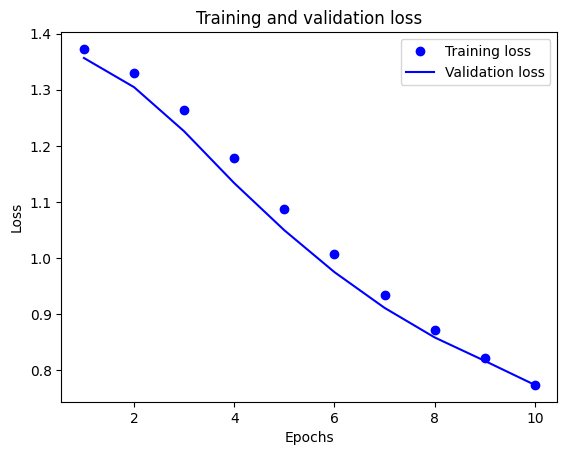

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

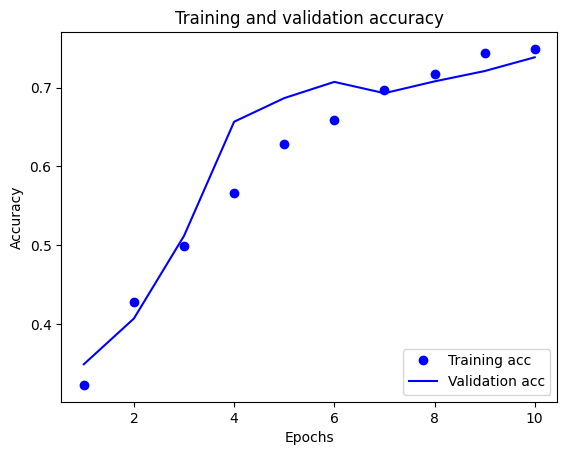

In [35]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

На этом графике точки представляют потери при обучении и точность, а сплошные линии — потери и точность при проверке.

Обратите внимание, что потери при обучении *уменьшаются* с каждой эпохой, а точность обучения *увеличивается* с каждой эпохой. Это ожидается при использовании оптимизации градиентного спуска — она должна минимизировать желаемое количество на каждой итерации.

Это не относится к потерям при проверке и точности — похоже, они достигают пика перед точностью обучения. Это пример переобучения: модель работает лучше на обучающих данных, чем на данных, которые она никогда раньше не видела. После этого момента модель чрезмерно оптимизируется и изучает представления, *специфичные* для обучающих данных, которые не *обобщаются* для тестовых данных.

В этом конкретном случае вы можете предотвратить переобучение, просто остановив обучение, когда точность проверки перестает увеличиваться. Один из способов сделать это — использовать обратный вызов tf.keras.callbacks.EarlyStopping.

## Экспортируем модель

В приведенном выше коде вы применили слой TextVectorization к набору данных перед подачей текста в модель. Если вы хотите, чтобы ваша модель могла обрабатывать необработанные строки (например, чтобы упростить ее развертывание), вы можете включить слой TextVectorization внутри вашей модели. Для этого вы можете создать новую модель, используя только что обученные веса.

In [36]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 4)

### Вывод по новым данным

Чтобы получить прогнозы для новых примеров, вы можете просто вызвать model.predict()..

In [39]:
examples = ["javascript"]
examples = tf.constant(examples)
export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.53060883, 0.4121429 , 0.6306924 , 0.41663146]], dtype=float32)

Включение логики предварительной обработки текста в вашу модель позволяет экспортировать модель для производства, что упрощает развертывание и снижает вероятность [перекоса при обучении/тестировании]

При выборе места применения слоя TextVectorization следует учитывать разницу в производительности. Использование его вне вашей модели позволяет вам выполнять асинхронную обработку ЦП и буферизацию данных при обучении на графическом процессоре. Итак, если вы тренируете свою модель на графическом процессоре, вы, вероятно, захотите использовать этот вариант, чтобы получить максимальную производительность при разработке вашей модели, а затем переключиться на включение слоя TextVectorization внутри вашей модели, когда вы будете готовы подготовиться к развертыванию. .


## Упражнение: многоклассовая классификация

В этом руководстве показано, как с нуля обучить двоичный классификатор на наборе данных IMDB. В качестве упражнения вы можете изменить этот блокнот, чтобы обучить многоклассовый классификатор предсказывать тег вопроса по программированию в [Stack Overflow](http://stackoverflow.com/).

Для вас подготовлен [набор данных](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz), содержащий несколько тысяч вопросов по программированию (например, «Как могу ли я отсортировать словарь по значению в Python?»), опубликованное в Stack Overflow. Каждый из них помечен ровно одним тегом (Python, CSharp, JavaScript или Java). Ваша задача — принять вопрос в качестве входных данных и спрогнозировать соответствующий тег, в данном случае Python.

Набор данных, с которым вы будете работать, содержит несколько тысяч вопросов, извлеченных из гораздо более крупного общедоступного набора данных Stack Overflow на сайте [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), который содержит более 17 миллионов постов.

Загрузив набор данных, вы обнаружите, что его структура каталогов аналогична набору данных IMDB, с которым вы работали ранее:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Примечание. Чтобы повысить сложность задачи классификации, слова Python, CSharp, JavaScript или Java в вопросах по программированию были заменены словом *пробел* (поскольку многие вопросы содержат язык, о котором они говорят).

Чтобы выполнить это упражнение, вам следует изменить этот блокнот для работы с набором данных Stack Overflow, внеся следующие изменения:

1. В верхней части записной книжки обновите код, загружающий набор данных IMDB, кодом для загрузки [набора данных Stack Overflow](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar. gz), который уже подготовлен. Поскольку набор данных Stack Overflow имеет аналогичную структуру каталогов, вам не потребуется вносить много изменений.

1. Измените последний слой вашей модели на «Dense(4)», так как теперь существует четыре выходных класса.

1. При компиляции модели измените потерю на `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. Это правильная функция потерь, которую можно использовать для задачи классификации нескольких классов, когда метки каждого класса являются целыми числами (в этом случае они могут быть 0, *1*, *2* или *3*). Кроме того, измените метрику на `metrics=['accuracy']`, поскольку это проблема классификации нескольких классов (`tf.metrics.BinaryAccuracy` используется только для двоичных классификаторов).

1. При построении графика точности во времени измените `binary_accuracy` и `val_binary_accuracy` на `accuracy` и `val_accuracy` соответственно.

1. Как только эти изменения будут завершены, вы сможете обучать многоклассовый классификатор.